In [53]:
# Install OpenSlide C library 
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [21]:
#import libraries.

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [22]:
# Get folder list.
folder_list = drive.ListFile({'q': "trashed=False"}).GetList()
for folder in folder_list:
    print('folder title: %s, id: %s' % (folder['title'], folder['id']))

folder title: level3and4, id: 17uBdsmztg-P3w3gq7JbtIU1TQ6QTJhhf
folder title: final_project_v2.ipynb, id: 1lbxYy9OiD4J3AnDRM0Cpsu1WwxWHqr_1
folder title: Youtube Link, id: 1bTs4281-J2Jks_7M96Tqr0MWeyEipuygs1CFzFCgJOA
folder title: Final_Presentation_Recording, id: 1hCcWzcv2ZwS6tlmSDr8Ds2MYTszPml8f
folder title: recording.conf, id: 1ZsVi4CamVR67cDK8aNhoE4ue6JkPQ8Ky
folder title: audio1082893673.m4a, id: 1ndoDuDVd4P54HRLZFVuMDrbmCb2gAnpy
folder title: video1082893673.mp4, id: 10-jIr0r0lrL3J1_8B8VixS57csAid4_7
folder title: final_project.ipynb, id: 1jOc2yP71n8iIWUBGLFA0-YfFXBSo88vV
folder title: Final Project Slides, id: 1k7u5hfYNarqj-8LvelaC99f7NU8kqVN1ul3AHrQeRi8
folder title: Dear Christina , id: 1lxNS7b6PgMfKrFP64OwRtbNrajWqx0gukuENnHDPwSg
folder title: tumor_059.xml, id: 1H5cKiD-poLonctYLDeektYJqI3Vohfui
folder title: tumor_078.tif, id: 1HP6dTrn6VWTaEFm2EYenygCAySd-uvUl
folder title: tumor_064.tif, id: 1pimL9loGrlYdVeCiuwEkkmIBuoQDquAB
folder title: tumor_059.tif, id: 1HH_wVpn9YsAdM8

In [23]:
slide_dir = '/gdrive/MyDrive/ADLFinalProject/slides/'
level_id = '17uBdsmztg-P3w3gq7JbtIU1TQ6QTJhhf'

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import shutil
import json
from datetime import datetime

import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

In [25]:
# Get files in folder
files = os.listdir(slide_dir)
print(files)

['tumor_001_mask.tif', 'tumor_001.xml', 'tumor_001.tif', 'tumor_002_mask.tif', 'tumor_002.tif', 'tumor_002.xml', 'tumor_005_mask.tif', 'tumor_005.xml', 'tumor_005.tif', 'tumor_012_mask.tif', 'tumor_012.xml', 'tumor_012.tif', 'tumor_019.xml', 'tumor_019_mask.tif', 'tumor_019.tif', 'tumor_023.xml', 'tumor_023_mask.tif', 'tumor_023.tif', 'tumor_031.xml', 'tumor_031_mask.tif', 'tumor_031.tif', 'tumor_035.xml', 'tumor_057.xml', 'tumor_057_mask.tif', 'tumor_075.xml', 'tumor_064.xml', 'tumor_081.xml', 'tumor_081_mask.tif', 'tumor_084.xml', 'tumor_078.xml', 'tumor_057.tif', 'tumor_075_mask.tif', 'tumor_064_mask.tif', 'tumor_084_mask.tif', 'tumor_035_mask.tif', 'tumor_078_mask.tif', 'tumor_059_mask.tif', 'tumor_035.tif', 'tumor_084.tif', 'tumor_075.tif', 'tumor_081.tif', 'tumor_059.tif', 'tumor_064.tif', 'tumor_078.tif', 'tumor_059.xml']


In [26]:
# Get filenames for slides & masks
slide_paths, tumor_mask_paths = [], []
for item in files:
    if item[-4:] == '.tif':
        if item[-8:-4] == 'mask':
            tumor_mask_paths.append(item)
        else:
            slide_paths.append(item)


tumor_mask_paths = sorted(tumor_mask_paths)
slide_paths = sorted(slide_paths)
assert len(tumor_mask_paths) == len(slide_paths)
slide_number = len(slide_paths)
slide_index = [item[6:9] for item in slide_paths]
print("There are %d slide-mask pairs." % slide_number)

There are 15 slide-mask pairs.


In [27]:
# Check if the numbers of slides and masks are matched up.
for slide, mask in zip(slide_paths, tumor_mask_paths):
    print(slide, mask)

tumor_001.tif tumor_001_mask.tif
tumor_002.tif tumor_002_mask.tif
tumor_005.tif tumor_005_mask.tif
tumor_012.tif tumor_012_mask.tif
tumor_019.tif tumor_019_mask.tif
tumor_023.tif tumor_023_mask.tif
tumor_031.tif tumor_031_mask.tif
tumor_035.tif tumor_035_mask.tif
tumor_057.tif tumor_057_mask.tif
tumor_059.tif tumor_059_mask.tif
tumor_064.tif tumor_064_mask.tif
tumor_075.tif tumor_075_mask.tif
tumor_078.tif tumor_078_mask.tif
tumor_081.tif tumor_081_mask.tif
tumor_084.tif tumor_084_mask.tif


In [28]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x, y), level, (width, height))
    im = im.convert('RGB')  # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [29]:
# get level info of all slides and size of level 0
for i, item in enumerate(slide_paths):
    real_path = slide_dir + item
    slide = open_slide(real_path)
    print("Slide no. %s with %d levels, width: %d, height: %d" % (
        slide_index[i], len(slide.level_dimensions),
        slide.level_dimensions[0][0], slide.level_dimensions[0][1]))

Slide no. 001 with 10 levels, width: 97792, height: 221184
Slide no. 002 with 10 levels, width: 97792, height: 219648
Slide no. 005 with 10 levels, width: 97792, height: 219648
Slide no. 012 with 10 levels, width: 97792, height: 215552
Slide no. 019 with 10 levels, width: 97792, height: 219648
Slide no. 023 with 10 levels, width: 97792, height: 221184
Slide no. 031 with 10 levels, width: 97792, height: 221184
Slide no. 035 with 10 levels, width: 97792, height: 221184
Slide no. 057 with 10 levels, width: 97792, height: 220672
Slide no. 059 with 10 levels, width: 97280, height: 221184
Slide no. 064 with 10 levels, width: 97792, height: 220672
Slide no. 075 with 9 levels, width: 90112, height: 78848
Slide no. 078 with 9 levels, width: 94208, height: 111104
Slide no. 081 with 9 levels, width: 90112, height: 100352
Slide no. 084 with 9 levels, width: 65536, height: 86016


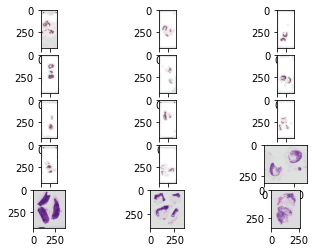

In [30]:
# show slides at highest level
ncol = 3
for i in range(slide_number):
    real_path = slide_dir + slide_paths[i]
    slide = open_slide(real_path)
    plt.subplot(np.ceil(slide_number / ncol), ncol, i + 1)
    level = len(slide.level_dimensions) - 1
    slide_image = read_slide(slide,
                             x=0,
                             y=0,
                             level=level,
                             width=slide.level_dimensions[level][0],
                             height=slide.level_dimensions[level][1])
    plt.imshow(slide_image)
plt.show()
     

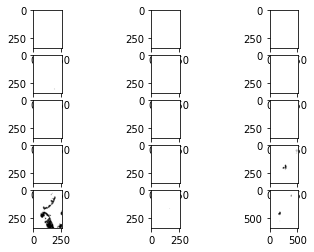

In [31]:
# show masks at highest level
for i in range(slide_number):
    real_path = slide_dir + tumor_mask_paths[i]
    mask = open_slide(real_path)
    plt.subplot(np.ceil(slide_number / ncol), ncol, i + 1)
    level = len(mask.level_dimensions) - 1
    mask_image = read_slide(mask,
                            x=0,
                            y=0,
                            level=level,
                            width=slide.level_dimensions[level][0],
                            height=slide.level_dimensions[level][1])
    mask_image = mask_image[:, :, 1]
    plt.imshow(mask_image, cmap=plt.cm.binary)
plt.show()

In [32]:
# Improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
# Mainly used to calculate the percentage of tissue area.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [33]:
def generate_data(slide, tumor_mask, level, stride, size,
                  neg_threshold=20, label_threshold=0.1,
                  tissue_threshold=0.15):
    
    pos_patch, pos_label, neg_patch, neg_label = [], [], [], []

    #divide patches by stride
    patch_size = (slide.level_dimensions[level][0] // stride,
                  slide.level_dimensions[level][1] // stride)
    
    neg_count = pos_count = 0
  
    pos_label_intensity = label_threshold * size ** 2
    for col in range(patch_size[0]):
        for row in range(patch_size[1]):
            # extract patch
            patch = read_slide(slide,
                               x=col * 2 ** level * stride,
                               y=row * 2 ** level * stride,
                               level=level,
                               width=size,
                               height=size)
            # find out how many percentage of the slide is tissue 
            tissue_pixels = find_tissue_pixels(patch)
            percent_tissue = len(tissue_pixels) / \
                (patch.shape[0] * patch.shape[1])
            if percent_tissue > tissue_threshold:
               
                # get mask
                mask = read_slide(tumor_mask,
                                  x=col * 2 ** level * stride,
                                  y=row * 2 ** level * stride,
                                  level=level,
                                  width=size,
                                  height=size)
                mask = np.expand_dims(np.array(mask[:, :, 0]), axis=-1)
                patch = np.expand_dims(np.array(patch[:, :, 0]), axis=-1)

                # save positive sample
                if np.sum(mask) > pos_label_intensity:
                    pos_count += 1
                    pos_patch.append(patch)
                    pos_label.append(mask)

                # save negative sample
                else:
                    neg_count += 1
                    neg_patch.append(patch)
                    neg_label.append(mask)
    
    neg_count = min(neg_threshold, neg_count)
    neg_pairs = list(zip(neg_patch, neg_label))  
    neg_pairs = sample(neg_pairs, neg_threshold)
    neg_patch, neg_label = zip(*neg_pairs)
    
    print('\nNum Pos: %d, Num Neg: %d' % (pos_count, neg_count))
    return [items and np.stack(items, axis=0) for items in [pos_patch, pos_label, neg_patch, neg_label]]

In [34]:
# save patches to VM disk in .npy format, then save to Google Drive
def save(nparray, target_dir, part, index, level, folder_id):
    fname = part + "_" + str(index) + "_" + str(level) + ".npy"
    path = os.path.join(target_dir, fname)
    np.save(open(path, "wb"), nparray)
    file_metadata = {'title': fname,
                     "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(path)
    folder.Upload()

In [35]:
# Create a folder to store .npy files on VM disk
# Use level 3 in our task
patch_level = "3and4"
path = os.path.join("/content", "level" + patch_level)
if not os.path.exists(path):
    os.mkdir(path)

In [36]:
# Extract patches from all avaliable tif img at level3
stride = 256
size = 256
folder_id = level_id


for i in range(0, slide_number):
    slide_path = slide_dir + slide_paths[i]
    slide = open_slide(slide_path)
    tumor_mask_path = slide_dir + tumor_mask_paths[i]
    tumor_mask = open_slide(tumor_mask_path)

    # generate labels
    pos_patches, pos_labels, neg_patches, neg_labels = generate_data(
        slide, tumor_mask, 3, stride, size)
    if not isinstance(pos_patches, list):
        save(pos_patches, path, "pos_patches", i, patch_level, folder_id)
        save(pos_labels, path, "pos_labels", i, patch_level, folder_id)
        save(neg_patches, path, "neg_patches", i, patch_level, folder_id)
        save(neg_labels, path, "neg_labels", i, patch_level, folder_id)
        print("\ntif %d saved" % i)


Num Pos: 7, Num Neg: 20

tif 0 saved

Num Pos: 1, Num Neg: 20

tif 1 saved

Num Pos: 2, Num Neg: 20

tif 2 saved

Num Pos: 1, Num Neg: 20

tif 3 saved

Num Pos: 4, Num Neg: 20

tif 4 saved

Num Pos: 2, Num Neg: 20

tif 5 saved

Num Pos: 66, Num Neg: 20

tif 6 saved

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 55, Num Neg: 20

tif 10 saved

Num Pos: 26, Num Neg: 20

tif 11 saved

Num Pos: 342, Num Neg: 20

tif 12 saved

Num Pos: 1, Num Neg: 20

tif 13 saved

Num Pos: 13, Num Neg: 20

tif 14 saved


In [37]:
# Extract patches from all avaliable tif img at level4
stride = 256
size = 256
folder_id = level_id


for i in range(0, slide_number):
    slide_path = slide_dir + slide_paths[i]
    slide = open_slide(slide_path)
    tumor_mask_path = slide_dir + tumor_mask_paths[i]
    tumor_mask = open_slide(tumor_mask_path)

    # generate labels
    pos_patches, pos_labels, neg_patches, neg_labels = generate_data(
        slide, tumor_mask, 4, stride, size)
    if not isinstance(pos_patches, list):
        save(pos_patches, path, "pos_patches", i, patch_level, folder_id)
        save(pos_labels, path, "pos_labels", i, patch_level, folder_id)
        save(neg_patches, path, "neg_patches", i, patch_level, folder_id)
        save(neg_labels, path, "neg_labels", i, patch_level, folder_id)
        print("\ntif %d saved" % i)


Num Pos: 2, Num Neg: 20

tif 0 saved

Num Pos: 0, Num Neg: 20

Num Pos: 1, Num Neg: 20

tif 2 saved

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 21, Num Neg: 20

tif 6 saved

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 0, Num Neg: 20

Num Pos: 19, Num Neg: 20

tif 10 saved

Num Pos: 7, Num Neg: 20

tif 11 saved

Num Pos: 106, Num Neg: 20

tif 12 saved

Num Pos: 0, Num Neg: 20

Num Pos: 5, Num Neg: 20

tif 14 saved


In [38]:
# Set the folder name 
data_dir = "/gdrive/MyDrive/ADLFinalProject/level3and4"

In [39]:
data_fnames = os.listdir(data_dir)

In [40]:
pos_patches, pos_labels, neg_patches, neg_labels = [], [], [], []
for fname in tqdm(sorted(data_fnames)):

    array = np.load(open(os.path.join(data_dir, fname), 'rb'))
    if "pos_patches" in fname:
        pos_patches.append(array)
    elif "pos_labels" in fname:
        pos_labels.append(array)
    elif "neg_patches" in fname:
        neg_patches.append(array)
    elif "neg_labels" in fname:
        neg_labels.append(array)

x_pos = np.concatenate(pos_patches, axis=0)
y_pos = np.concatenate(pos_labels, axis=0)
x_neg = np.concatenate(neg_patches, axis=0)
y_neg = np.concatenate(neg_labels, axis=0)

print(x_pos.shape[0])
print(y_pos.shape[0])

assert x_pos.shape[0] == y_pos.shape[0]
#assert x_neg.shape[0] == y_neg.shape[0]

x_pos.shape, y_pos.shape, x_neg.shape, y_neg.shape

100%|██████████| 72/72 [00:12<00:00,  5.87it/s]

676
676


((676, 256, 256, 1),
 (676, 256, 256, 1),
 (360, 256, 256, 1),
 (360, 256, 256, 1))

In [41]:
# compare the img & mask & prediction.
# or display img only.
# offset: offset for img index that want to be displayed, default: 0
# nrow: number of images to be shown
# img, mask, pred are of shape (n, width, height, channels)
def show_image(img, mask=None, pred=None, nrow=5, offset=0):
    print('Sequence: Img, Mask, Prediction')
    plt.figure(figsize=(7, 7))
    ncol = 1 + (mask is not None) + (pred is not None)
    for i in range(nrow):
        plt.subplot(nrow, ncol, ncol * i + 1)
        plt.axis("off")
        plt.imshow(np.squeeze(img[i + offset]), cmap=plt.cm.binary)
        
        if mask is not None:
            plt.subplot(nrow, ncol, ncol * i + 2)
            plt.axis("off")
            # np.squeeze: Remove single-dimensional entries from the shape of an array to display img
            plt.imshow(np.squeeze(mask[i + offset]), cmap=plt.cm.binary)  
            
        if pred is not None:
            plt.subplot(nrow, ncol, ncol * i + 3)
            plt.axis("off")
            plt.imshow(np.squeeze(pred[i + offset]), cmap=plt.cm.binary) 

Sequence: Img, Mask, Prediction


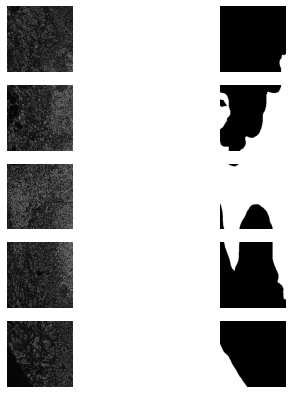

In [42]:
# show some patches & corrsponding labels 
show_image(x_pos, y_pos, nrow=5, offset=40)

In [43]:
# Don't include patches with no tumor, it decreases learning power 

x = x_pos / 255.0
y = y_pos
    
x.shape, y.shape

((676, 256, 256, 1), (676, 256, 256, 1))

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((540, 256, 256, 1),
 (136, 256, 256, 1),
 (540, 256, 256, 1),
 (136, 256, 256, 1))

In [45]:
#unet model
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv2DTranspose(512, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = 'he_normal')(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv2DTranspose(256, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = 'he_normal')(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv2DTranspose(128, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = 'he_normal')(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(Conv2DTranspose(64, kernel_size = (4,4), strides = (2,2), padding = 'same', kernel_initializer = 'he_normal')(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    return model
    
model = unet(input_size=(256, 256, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 concatenate_3 (Concatenate)    (None, 256, 256, 12  0           ['conv2d_1[0][0]',               
                                8)                                'conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 256, 256, 2)  1154        ['conv2d_21[0][0]']              
          

In [46]:
history = model.fit(x_train, y_train, 16, 10, validation_data=(x_test, y_test))

Epoch 1/10
34/34 [==============================] - 1992s 59s/step - loss: 0.6905 - accuracy: 0.5678 - val_loss: 0.6833 - val_accuracy: 0.5742
Epoch 2/10
34/34 [==============================] - 1972s 58s/step - loss: 0.6408 - accuracy: 0.5699 - val_loss: 0.6219 - val_accuracy: 0.5742
Epoch 3/10
34/34 [==============================] - 1956s 58s/step - loss: 0.5968 - accuracy: 0.6236 - val_loss: 0.6428 - val_accuracy: 0.6830
Epoch 4/10
34/34 [==============================] - 1954s 58s/step - loss: 0.6072 - accuracy: 0.7503 - val_loss: 0.5772 - val_accuracy: 0.8317
Epoch 5/10
34/34 [==============================] - 1951s 58s/step - loss: 0.5659 - accuracy: 0.8015 - val_loss: 0.5709 - val_accuracy: 0.7961
Epoch 6/10
34/34 [==============================] - 1946s 57s/step - loss: 0.5682 - accuracy: 0.7870 - val_loss: 0.5314 - val_accuracy: 0.8512
Epoch 7/10
34/34 [==============================] - 1942s 57s/step - loss: 0.5243 - accuracy: 0.8247 - val_loss: 0.4290 - val_accuracy: 0.8251

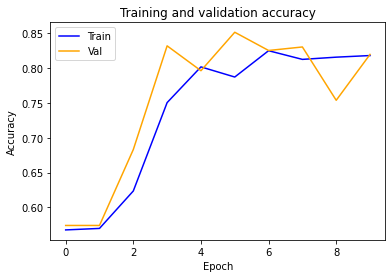

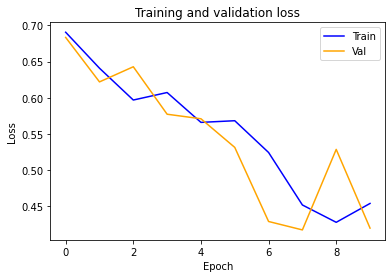

In [47]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  
plot(history)


In [48]:
# Predict patches, return binary imgs
def predict(model, x_test):
    pred = model.predict(x_test)
    pred = np.where(pred > 0.5, 1, 0)
    return pred

In [49]:
pred = predict(model, x_test)

5/5 [==============================] - 129s 24s/step


Sequence: Img, Mask, Prediction


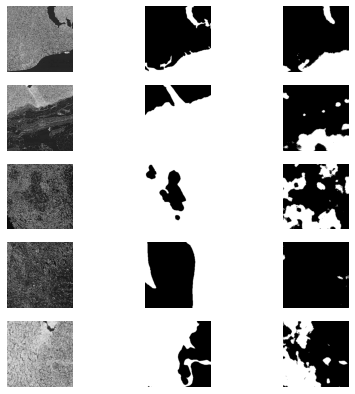

In [50]:
show_image(x_test, y_test, pred, offset=125)

In [51]:
neg_pred = predict(model, x_neg)

12/12 [==============================] - 342s 28s/step


Sequence: Img, Mask, Prediction


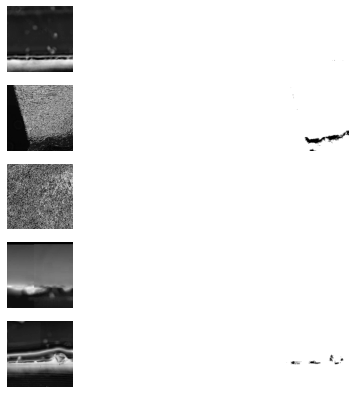

In [52]:
show_image(x_neg, y_neg, neg_pred, offset=25)